In [ ]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch_niff.resnet_niff_splitconv import resnet50

## Initialize input feature maps for NIFF

In [ ]:
imageheight = 56
imagewidth = 56

mask56 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)

imageheight = 28
imagewidth = 28

mask28 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)


imageheight = 14
imagewidth = 14

mask14 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)

## Kernel Mass Ratio for each layer

Text(0.5, 1.0, 'ResNet-50')

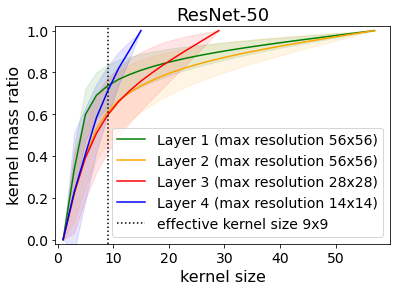

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model and model weights
model = resnet50(num_classes=1000)
path = "/checkpoint-best.pth" #path to model weights
model.load_state_dict(path)

    
model = model.to(device)
model.eval()



# iterate over each layer to get the weights of our NIFF
# for each layer select NIFF for the real and imaginary part
# feed each NIFF with the corresponding input feature maps
# and combine real and imaginary part
# afterwards tranformation back into the spatial domain via IFFT
k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer1[i].conv2[0].mlp_imag
    partmodel_real = model.layer1[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

max3 = torch.sum(torch.sum(abs(k), axis=1),axis=1)

l = [] 
s = []

# compute kernel mass ratio for each possible spatial kernel size
for i in range(int(k.size()[1]/2)):
        j = (torch.sum(torch.sum(abs(k[:,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i]), axis=1), axis=1)/max3).cpu().detach().numpy()
        l.append(np.mean(j))
        s.append(np.std(j))

        
l.append(1)
s.append(0)
# plot the mean kernelmass ration 
plt.plot(np.arange(1,58, 2), l, label='Layer 1 (max resolution 56x56)', color='g')
# as well as the actual maxmial and minimal kernel mass ratio for each spatial kernel size
plt.fill_between(np.arange(1,58, 2),np.asarray(l)-np.asarray(s),np.asarray(l)+np.asarray(s),alpha=.1, color='g') 



k = None
ies = [1,2,3]

for i in ies:
    partmodel_imag = model.layer2[i].conv2[0].mlp_imag
    partmodel_real = model.layer2[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

max3 = torch.sum(torch.sum(abs(k), axis=1),axis=1)

l = [] 
s = []

for i in range(int(k.size()[1]/2)):
        j = (torch.sum(torch.sum(abs(k[:,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i]), axis=1), axis=1)/max3).cpu().detach().numpy()
        l.append(np.mean(j))
        s.append(np.std(j))


l.append(1)
s.append(0)
plt.plot(np.arange(1,58, 2), l, label='Layer 2 (max resolution 56x56)', color='orange')
plt.fill_between(np.arange(1,58, 2),np.asarray(l)-np.asarray(s),np.asarray(l)+np.asarray(s),alpha=.1, color='orange')



k = None
ies = [1,2,3,4,5]

for i in ies:
    partmodel_imag = model.layer3[i].conv2[0].mlp_imag
    partmodel_real = model.layer3[i].conv2[0].mlp_real

    treal = partmodel_real(mask28)
    timag = partmodel_imag(mask28)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])
        

max3 = torch.sum(torch.sum(abs(k), axis=1),axis=1)

l = [] 
s = []

for i in range(int(k.size()[1]/2)):
        j = (torch.sum(torch.sum(abs(k[:,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i]), axis=1), axis=1)/max3).cpu().detach().numpy()
        l.append(np.mean(j))
        s.append(np.std(j))

l.append(1)
s.append(0)
plt.plot(np.arange(1,30, 2), l, label='Layer 3 (max resolution 28x28)', color='r')
plt.fill_between(np.arange(1,30, 2),np.asarray(l)-np.asarray(s),np.asarray(l)+np.asarray(s),alpha=.1, color='r')



k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer4[i].conv2[0].mlp_imag
    partmodel_real = model.layer4[i].conv2[0].mlp_real

    treal = partmodel_real(mask14)
    timag = partmodel_imag(mask14)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

max4 = torch.sum(torch.sum(abs(k), axis=1),axis=1)

l = [] 
s = []

for i in range(int(k.size()[1]/2)):
        j = (torch.sum(torch.sum(abs(k[:,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i,int(k.size()[1]/2)-i:int(k.size()[1]/2)+i]), axis=1), axis=1)/max4).cpu().detach().numpy()
        l.append(np.mean(j))
        s.append(np.std(j))

l.append(1)
s.append(0)
plt.plot(np.arange(1,16, 2), l, label='Layer 4 (max resolution 14x14)', color='b')
plt.fill_between(np.arange(1,16, 2),np.asarray(l)-np.asarray(s),np.asarray(l)+np.asarray(s),alpha=.1, color='b')

# add vertical line at kernelsize 9x9
plt.axvline(x=9, color='black', linestyle=':', label='effective kernel size 9x9')
plt.ylabel('kernel mass ratio', fontsize=16)
plt.xlabel('kernel size', fontsize=16)
plt.ylim(-0.02,1.02)
plt.xlim(-0.4)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ResNet-50', fontsize=18)
